In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [7]:
df = pd.read_csv("avocado.csv", na_values = "NaN")

In [8]:
df.head() #to have an overview of dataset.

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


Two quick fixes shall be made here before go further: 
* The column "Unnamed: 0" is obviously an unnecessary column, 
* And I prefer column names lowercase and with underline instead of space.


In [9]:
df = df.drop("Unnamed: 0", axis = 1)

In [10]:
df = df.rename(columns={"Date": "date","AveragePrice": "average_price","Region":"region","Total Volume":"total_volume","Total Bags":"total_bags","Small Bags":"small_bags","Large Bags":"large_bags","XLarge Bags":"xlarge_bags"})

Columns are explained in data page https://www.kaggle.com/neuromusic/avocado-prices as follows:
* Date - The date of the observation
* AveragePrice - the average price of a single avocado
* type - conventional or organic
* year - the year
* Region - the city or region of the observation
* Total Volume - Total number of avocados sold
* 4046 - Total number of avocados with PLU 4046 sold
* 4225 - Total number of avocados with PLU 4225 sold
* 4770 - Total number of avocados with PLU 4770 sold

Lets check if data types are well prepared.

In [11]:
df.dtypes

date              object
average_price    float64
total_volume     float64
4046             float64
4225             float64
4770             float64
total_bags       float64
small_bags       float64
large_bags       float64
xlarge_bags      float64
type              object
year               int64
region            object
dtype: object

We have the categorical variables "type","region"
We will not use it for this time.

Before we start an explatory analysis, it is best to seperate test set to avoid an obvious bias. Test set should not effect our analysis.

In [12]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.2, random_state = 42)

We will work on train set, until we feel OK with a good model. In this notebook I am planning to go compare regression algortihms and hopefully find a good regression algortihm to predict avocado prices.

In [13]:
categoricals = ["type"] # In this notebook, we wont use region variable
numericals = ['average_price', 'total_volume', '4046', '4225',
       '4770', 'total_bags', 'small_bags', 'large_bags', 'xlarge_bags',
       'year']

In [14]:
for i in categoricals:
    print(train[i].value_counts())
    print("***************************")

conventional    7306
organic         7293
Name: type, dtype: int64
***************************


* It seems perfectly balanced. It will not cause an error in our prediction hopefully.

## Visualize the data, gain more insights


Histograms are useful to distribution of variables, also to see outliers.

In [15]:
def plot_histogram(var,df):
    plt.figure(num=None, figsize=(15,9), dpi=150, facecolor='w', edgecolor='r')
    sns.histplot(data=df, x= var)
    plt.title("Histogram of '{var_name}'".format(var_name=str(var)))
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.xticks(rotation=90)
    plt.show()

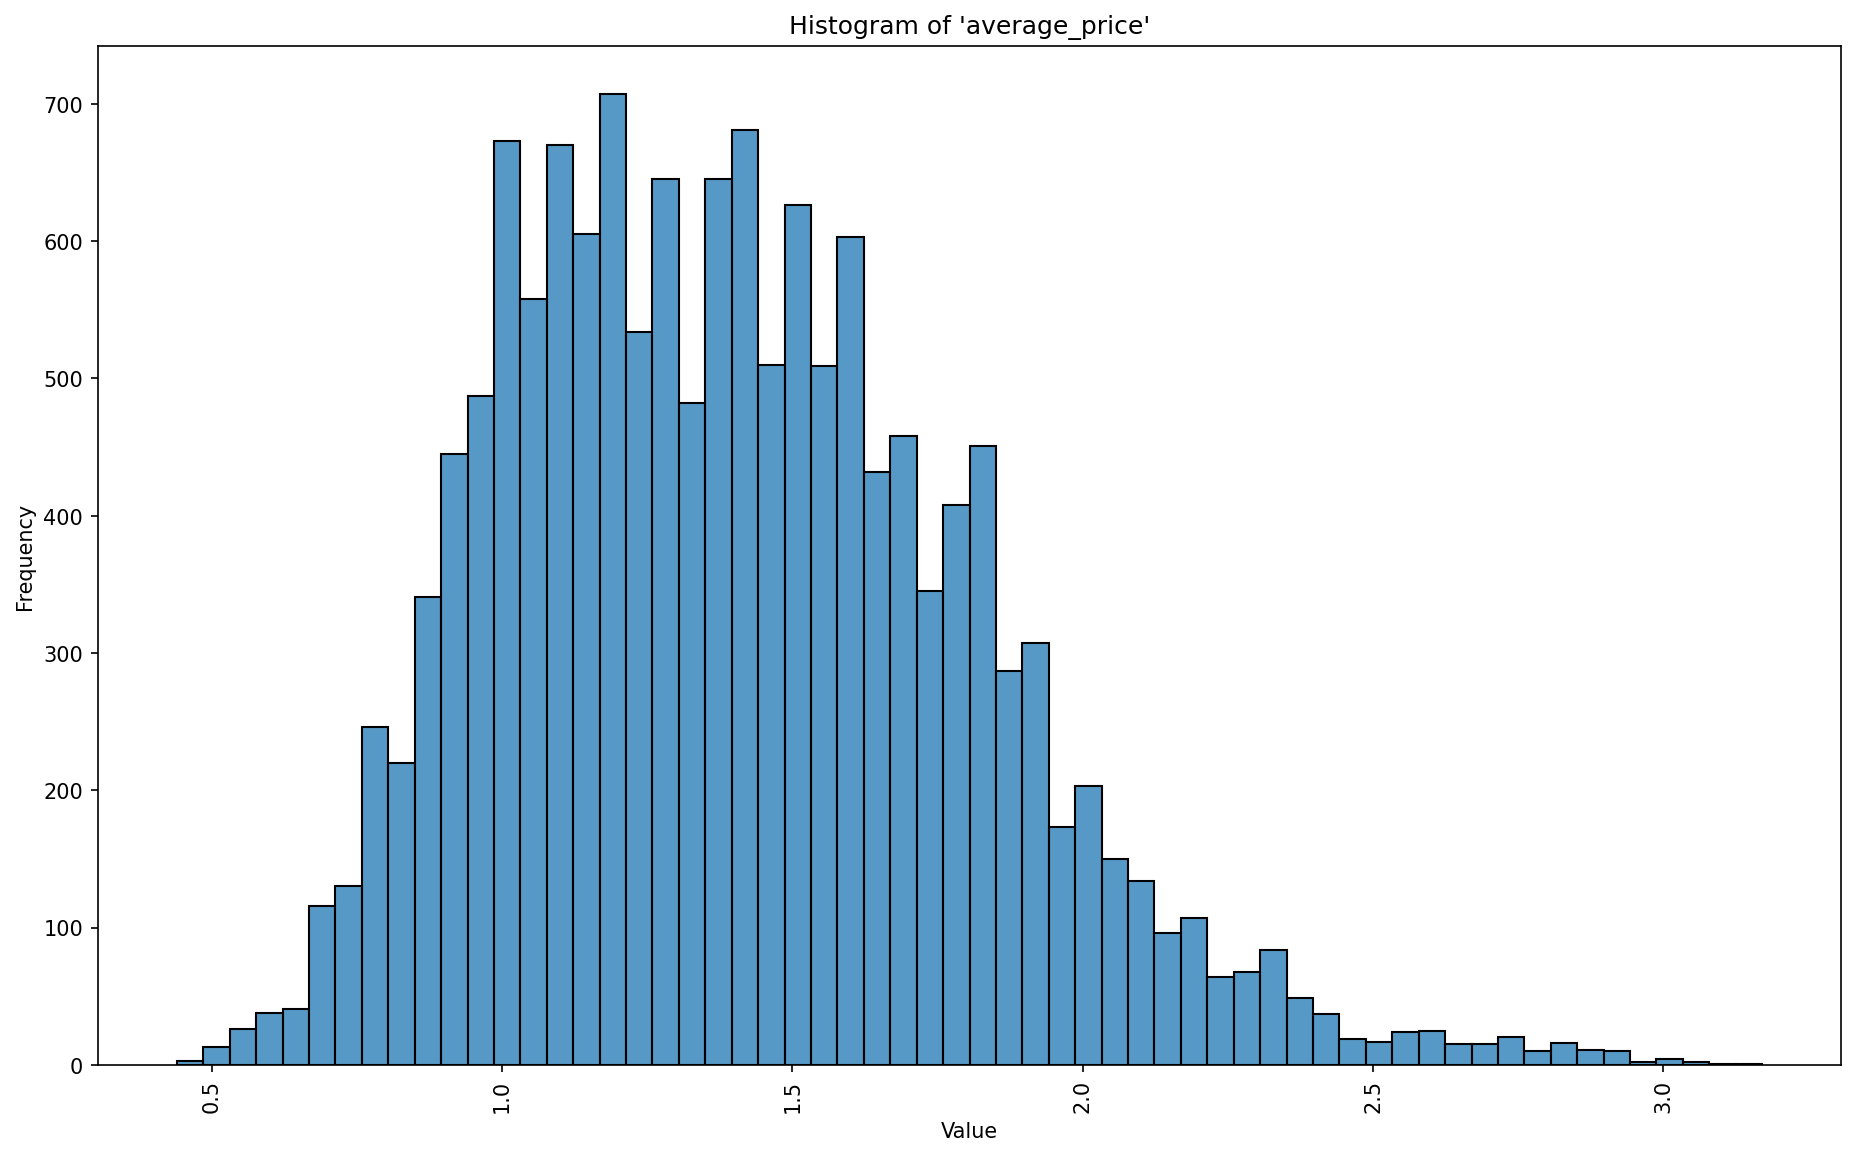

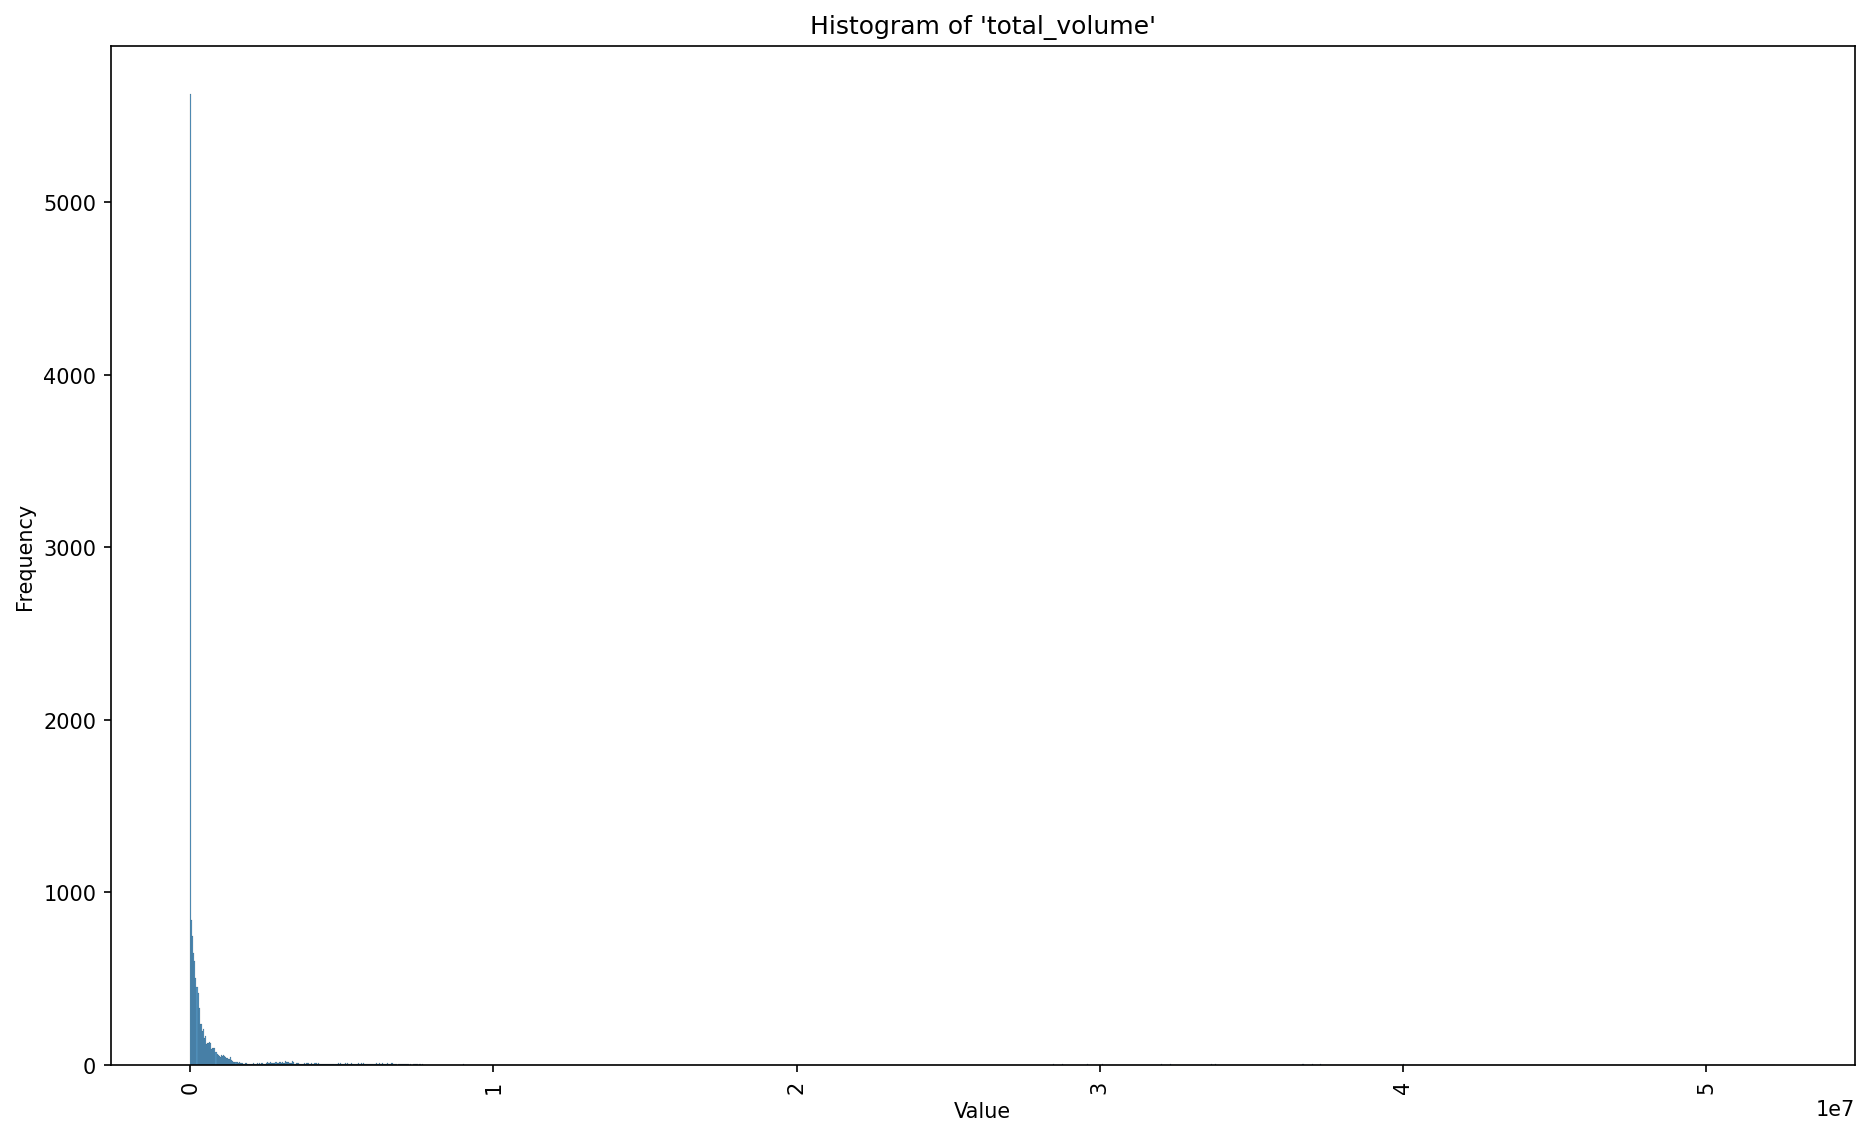

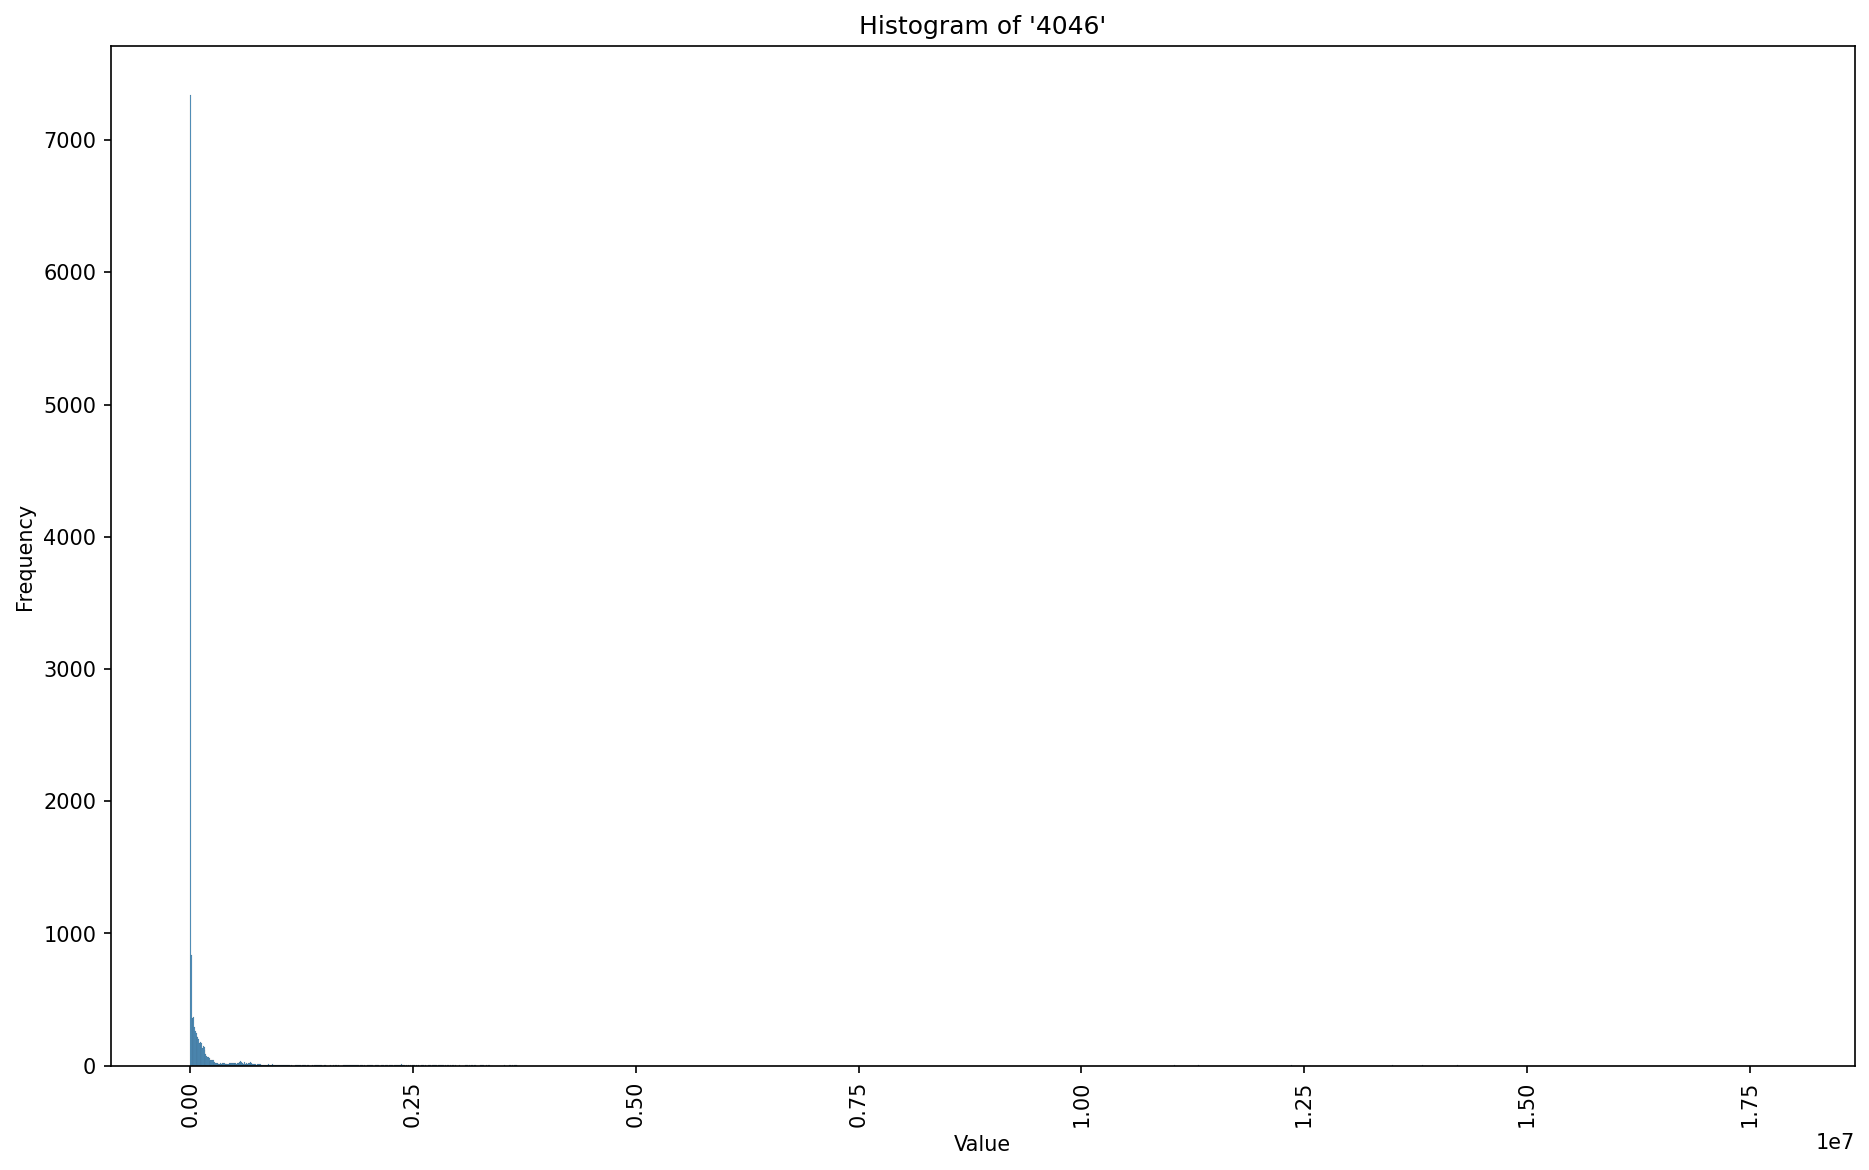

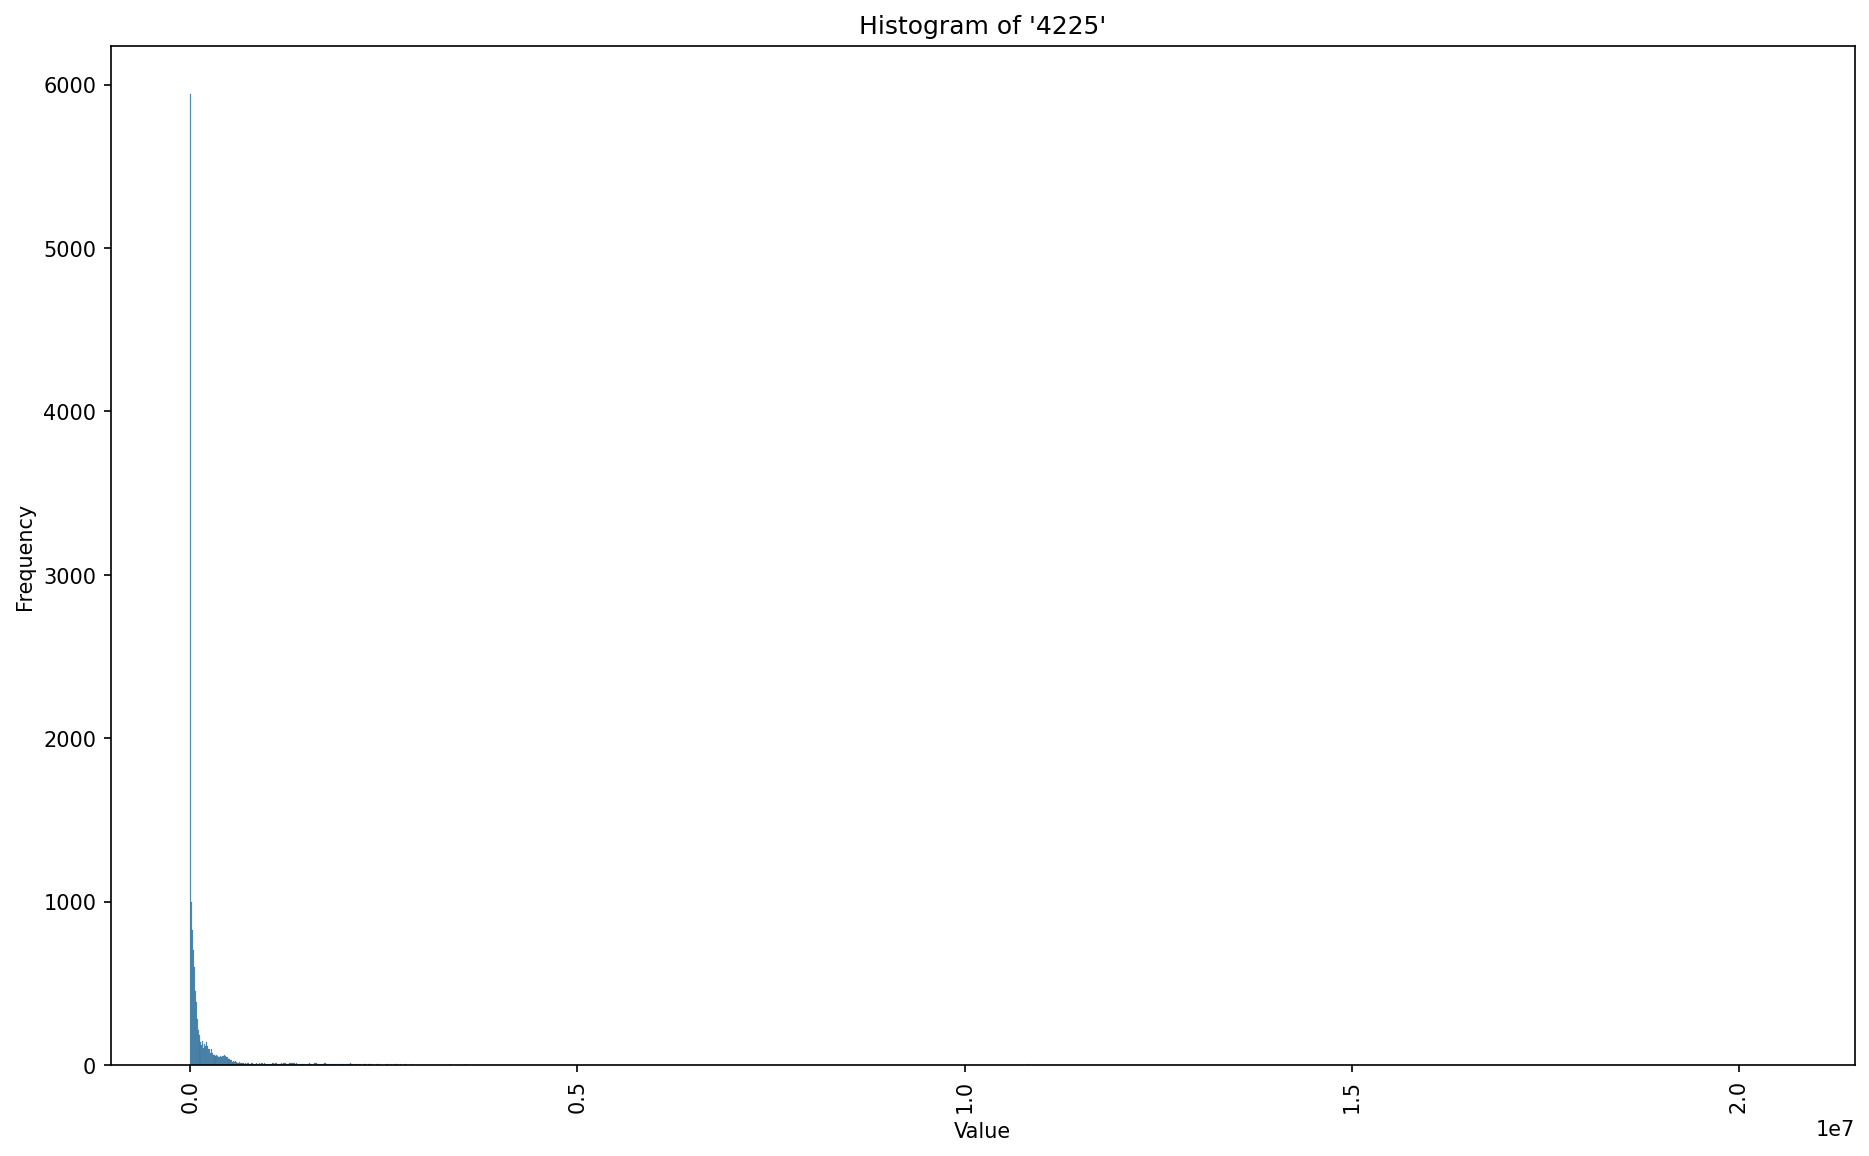

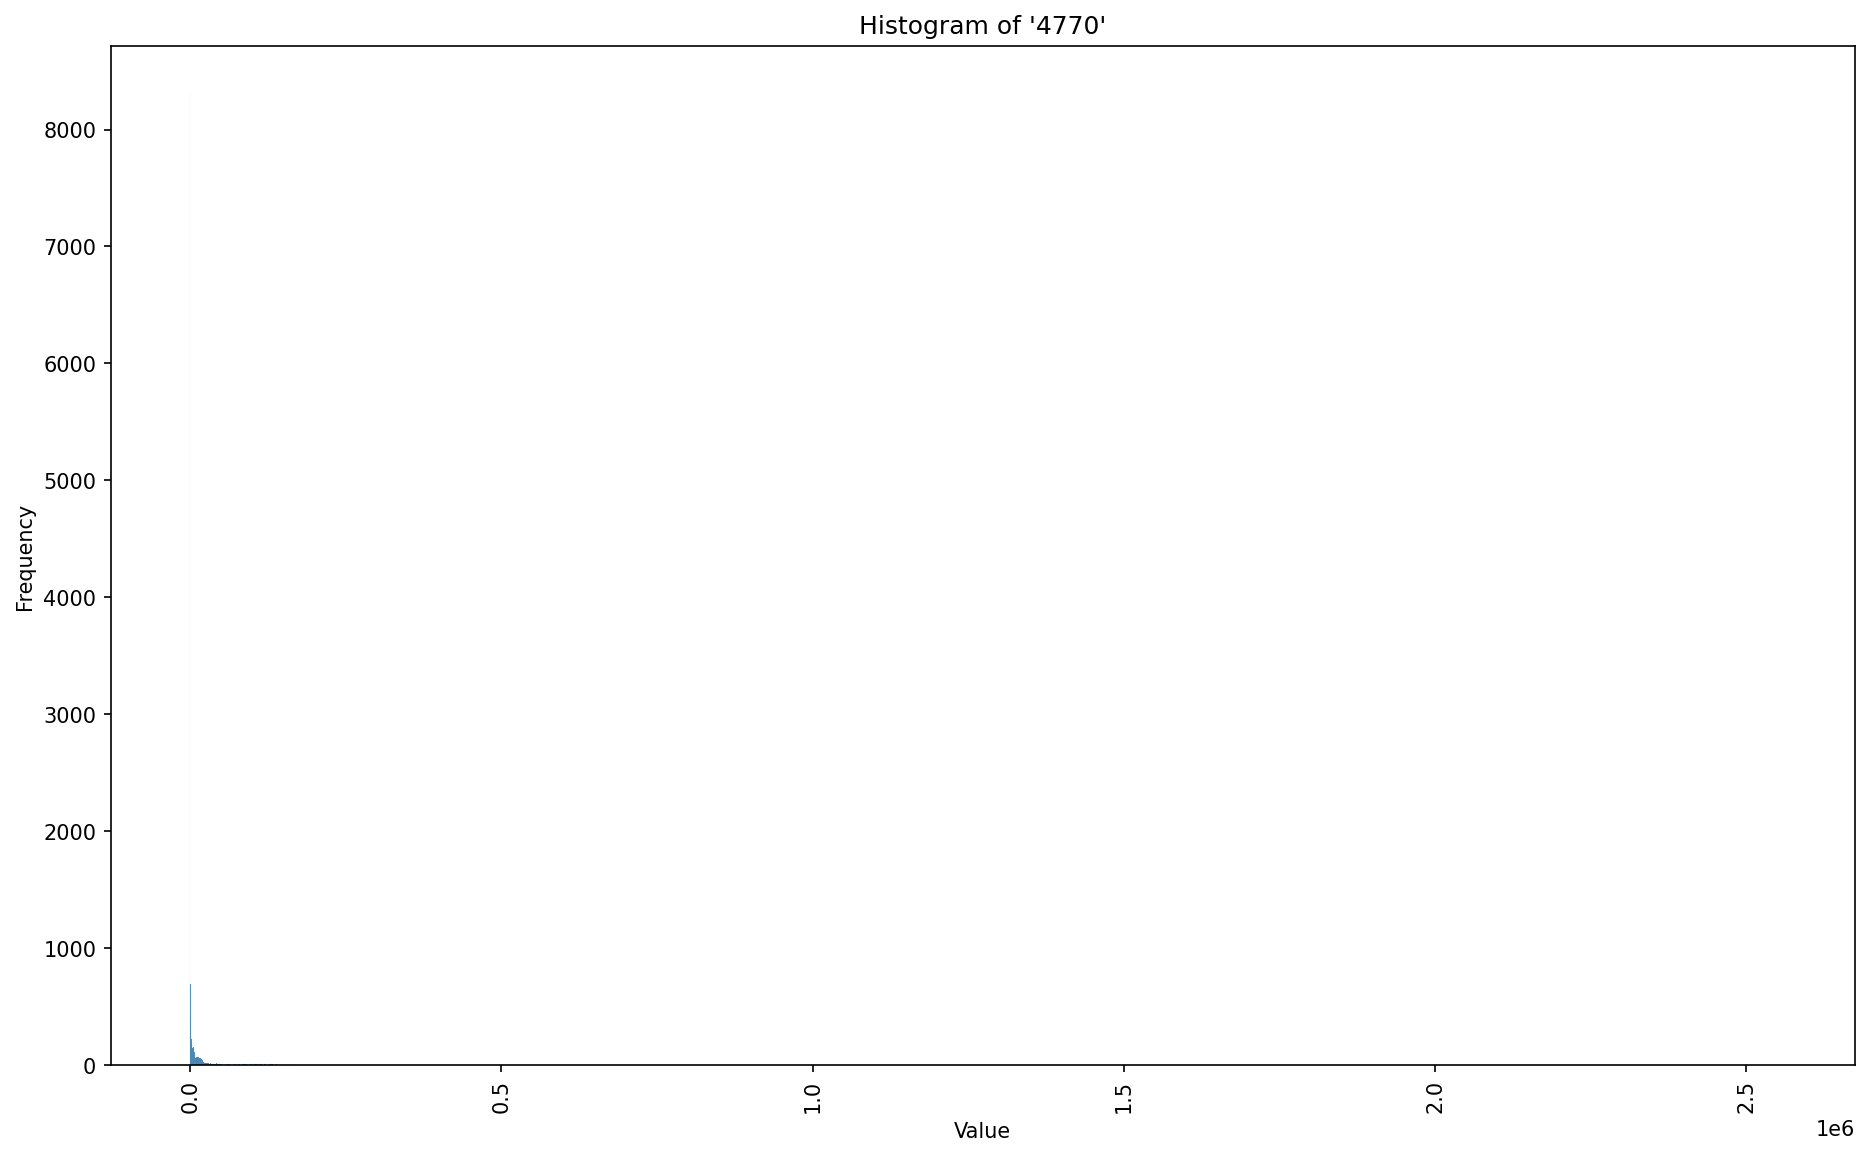

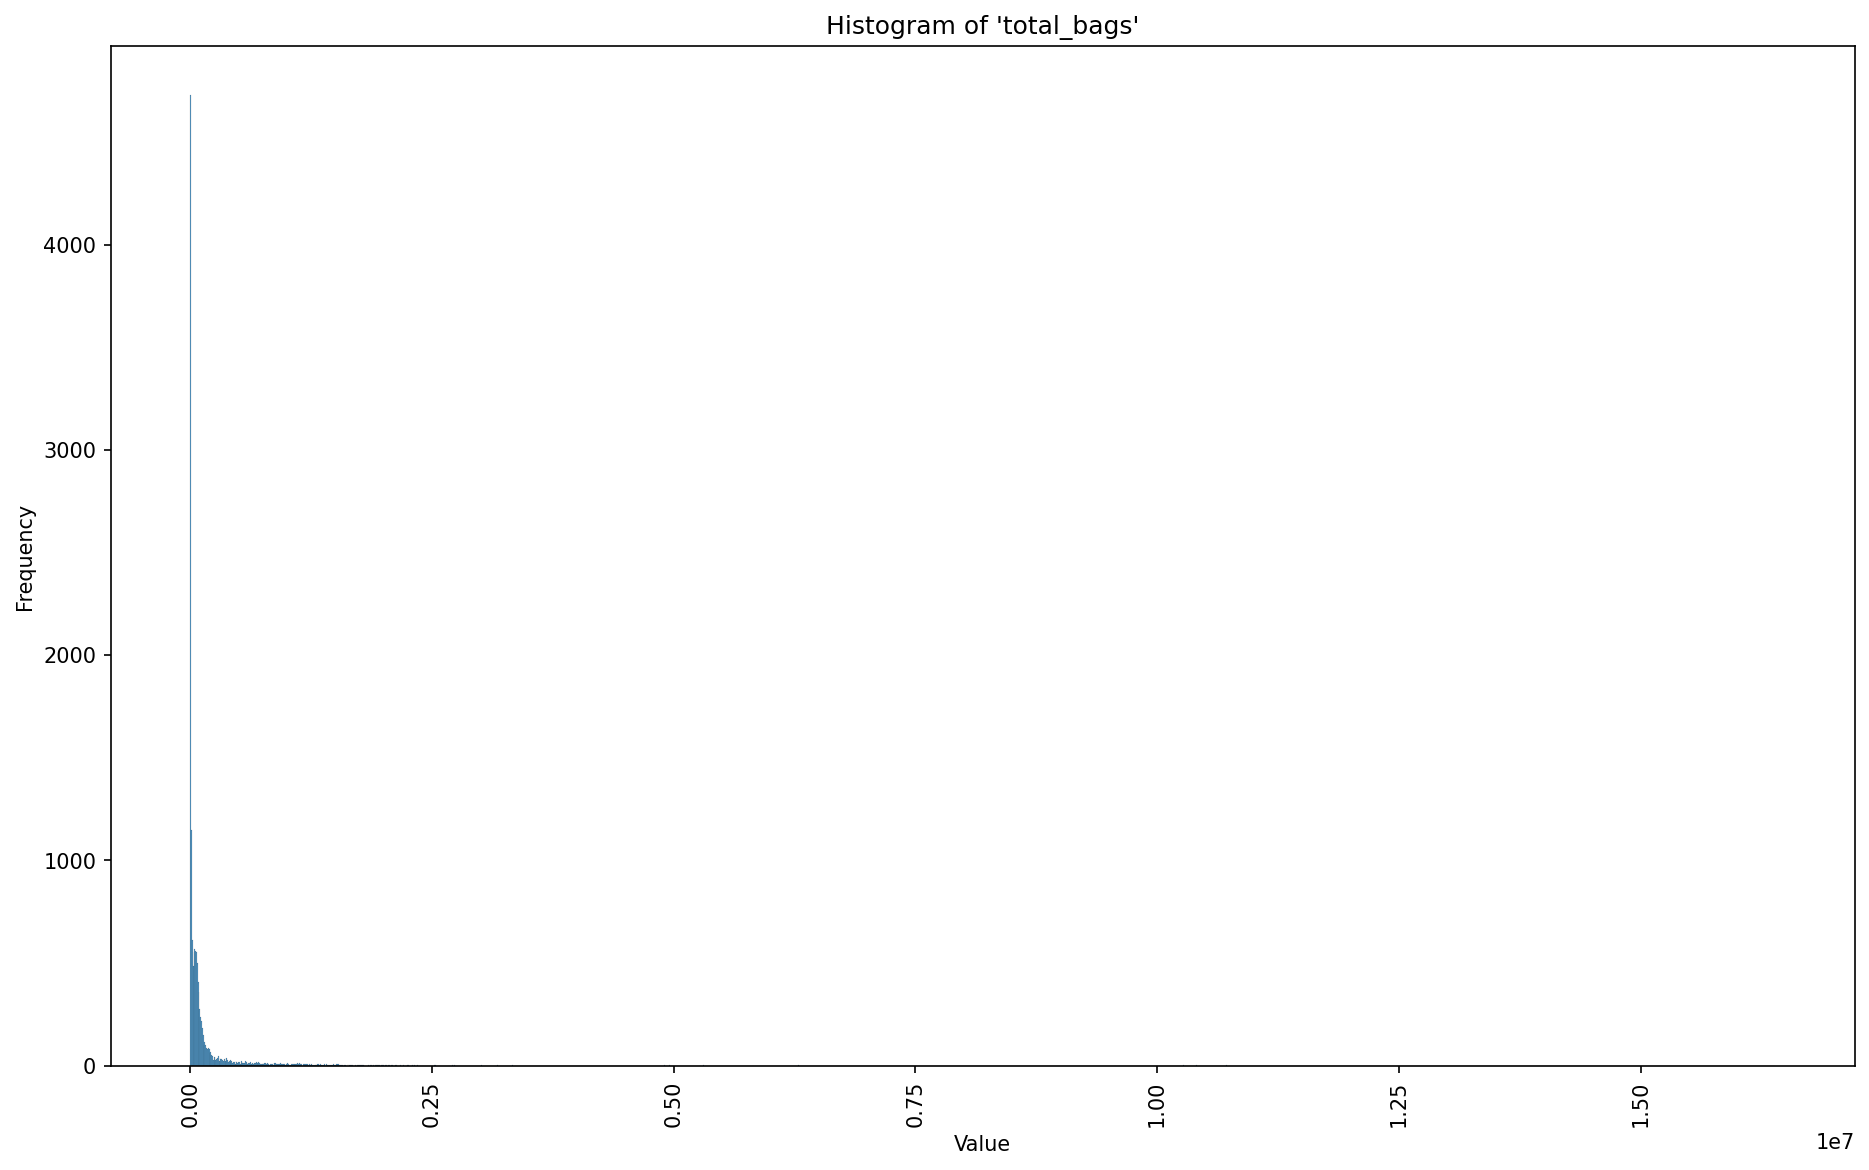

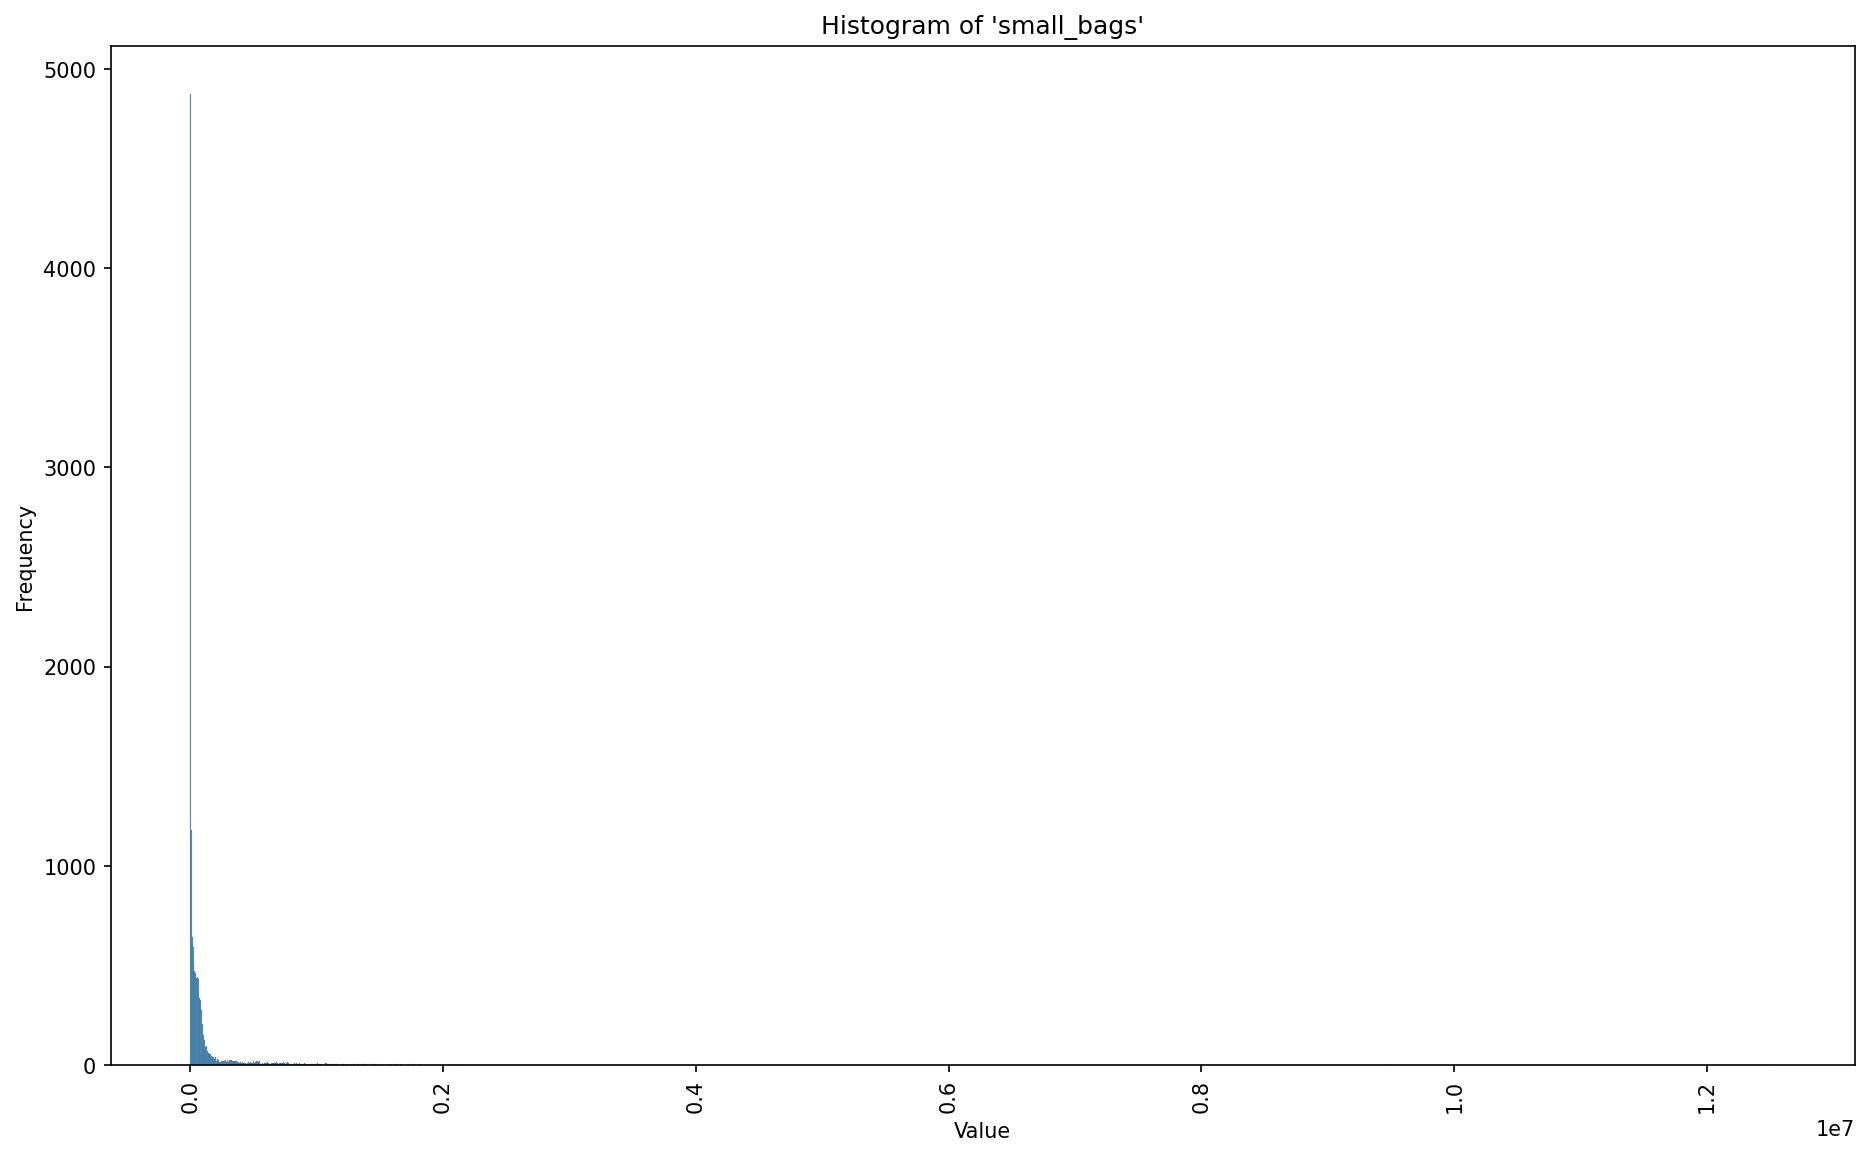

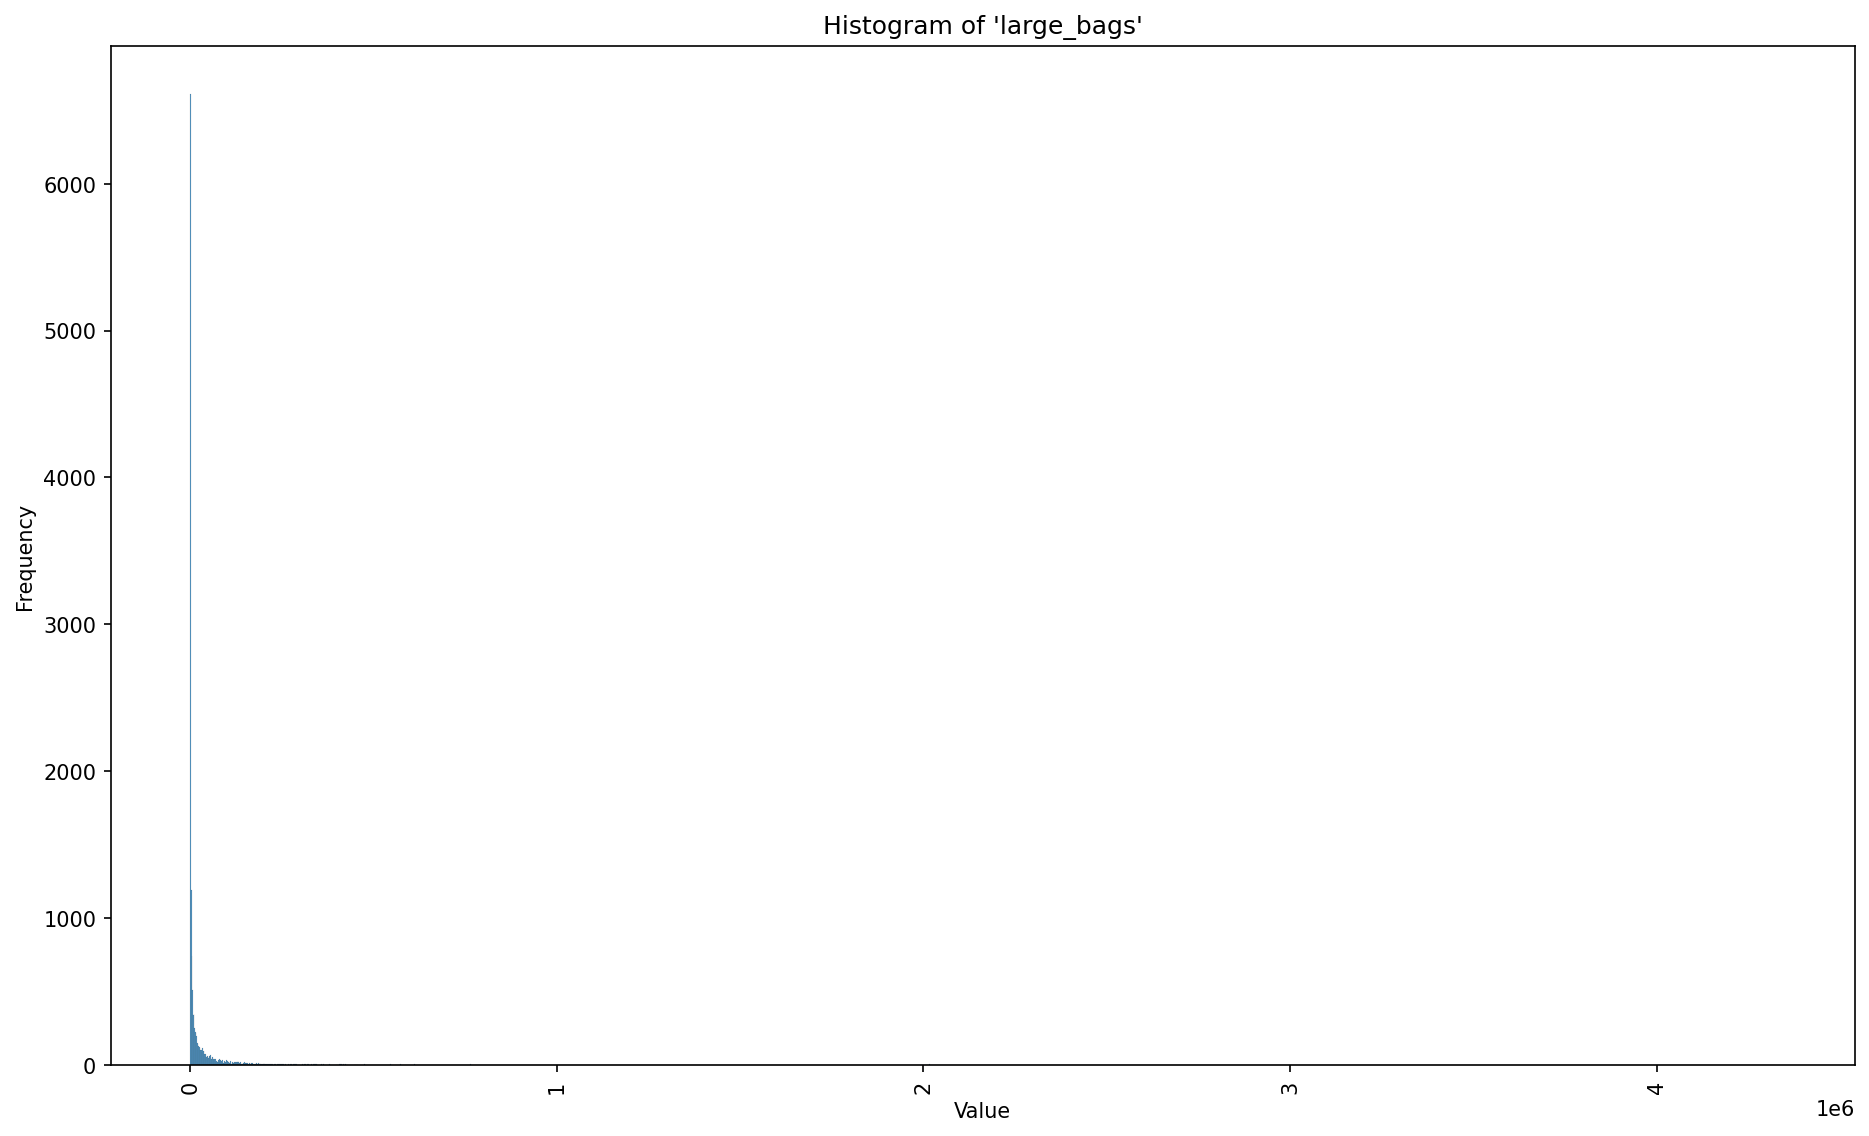

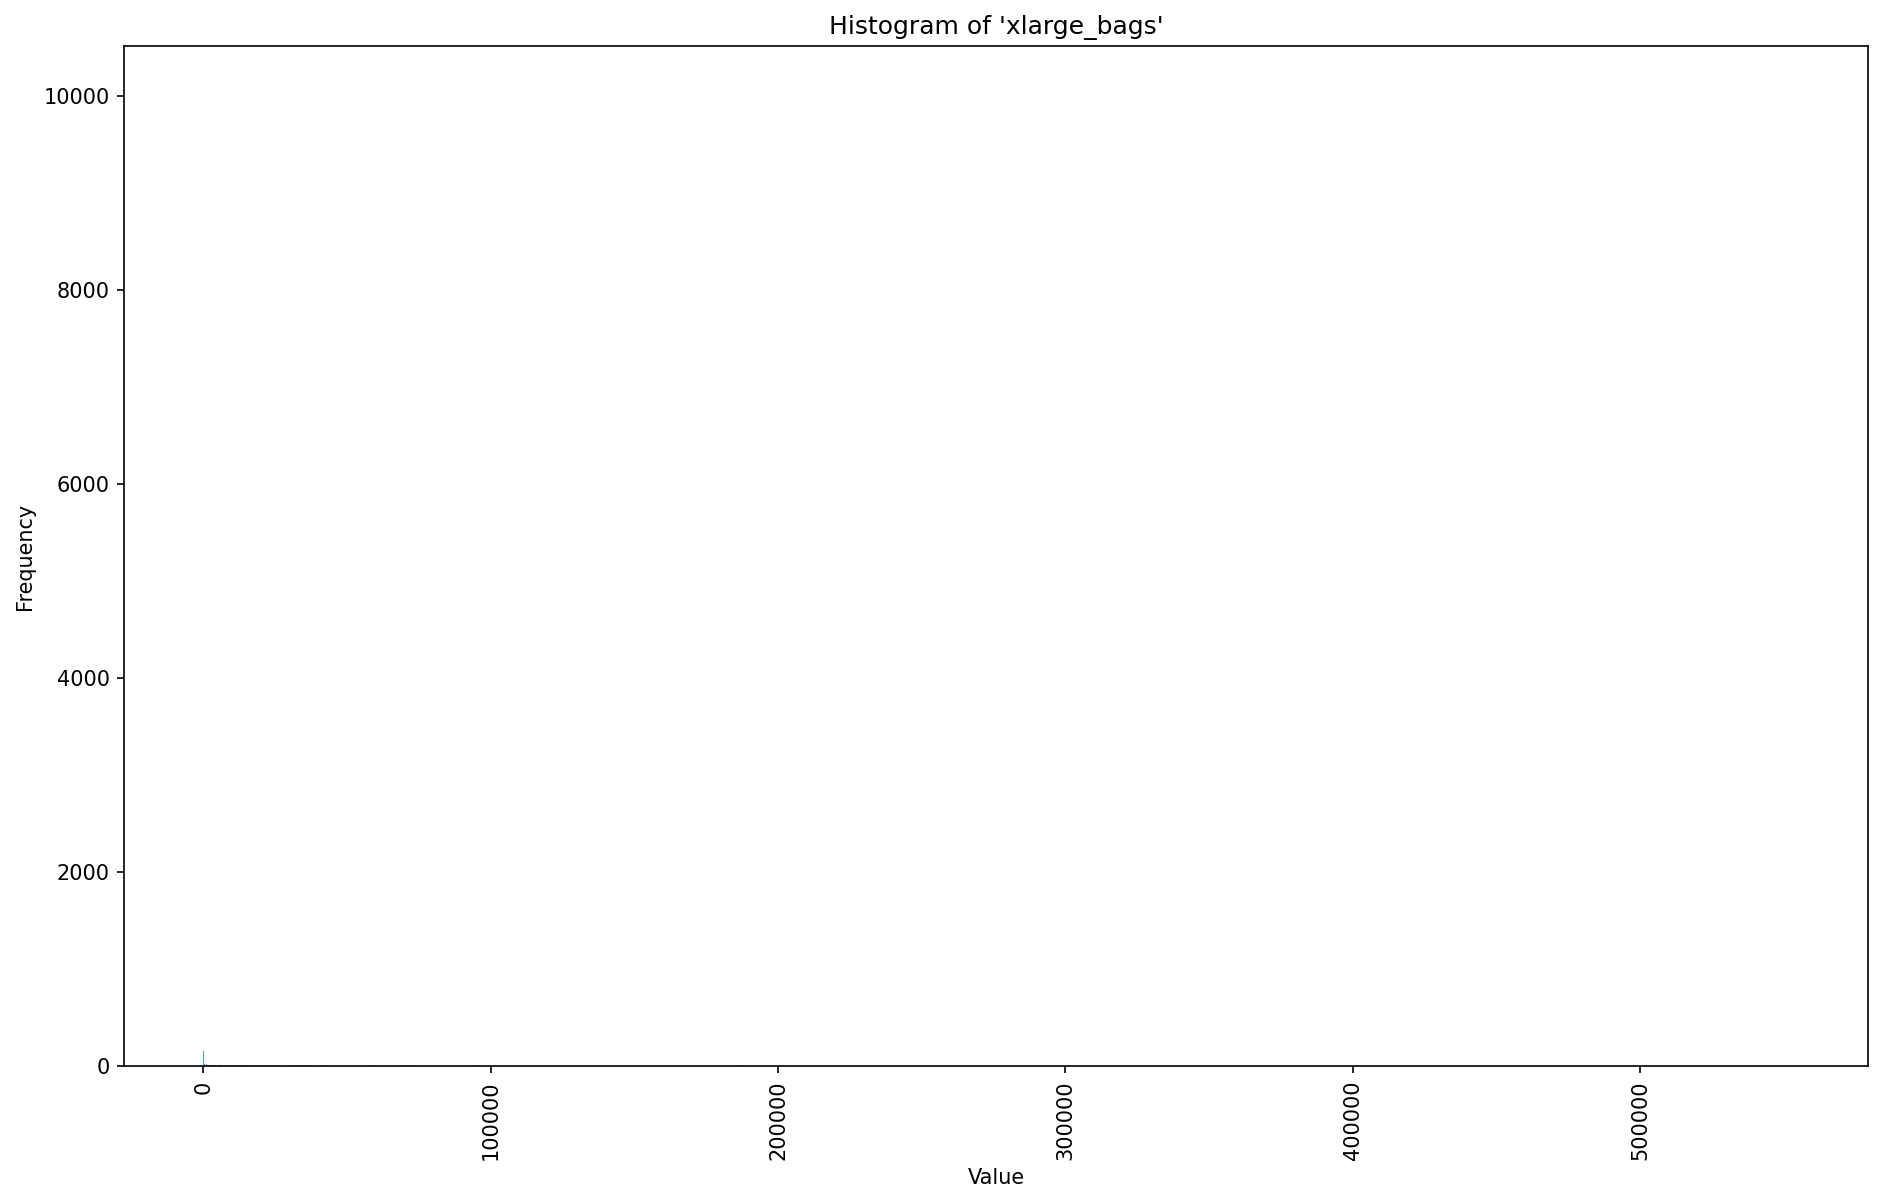

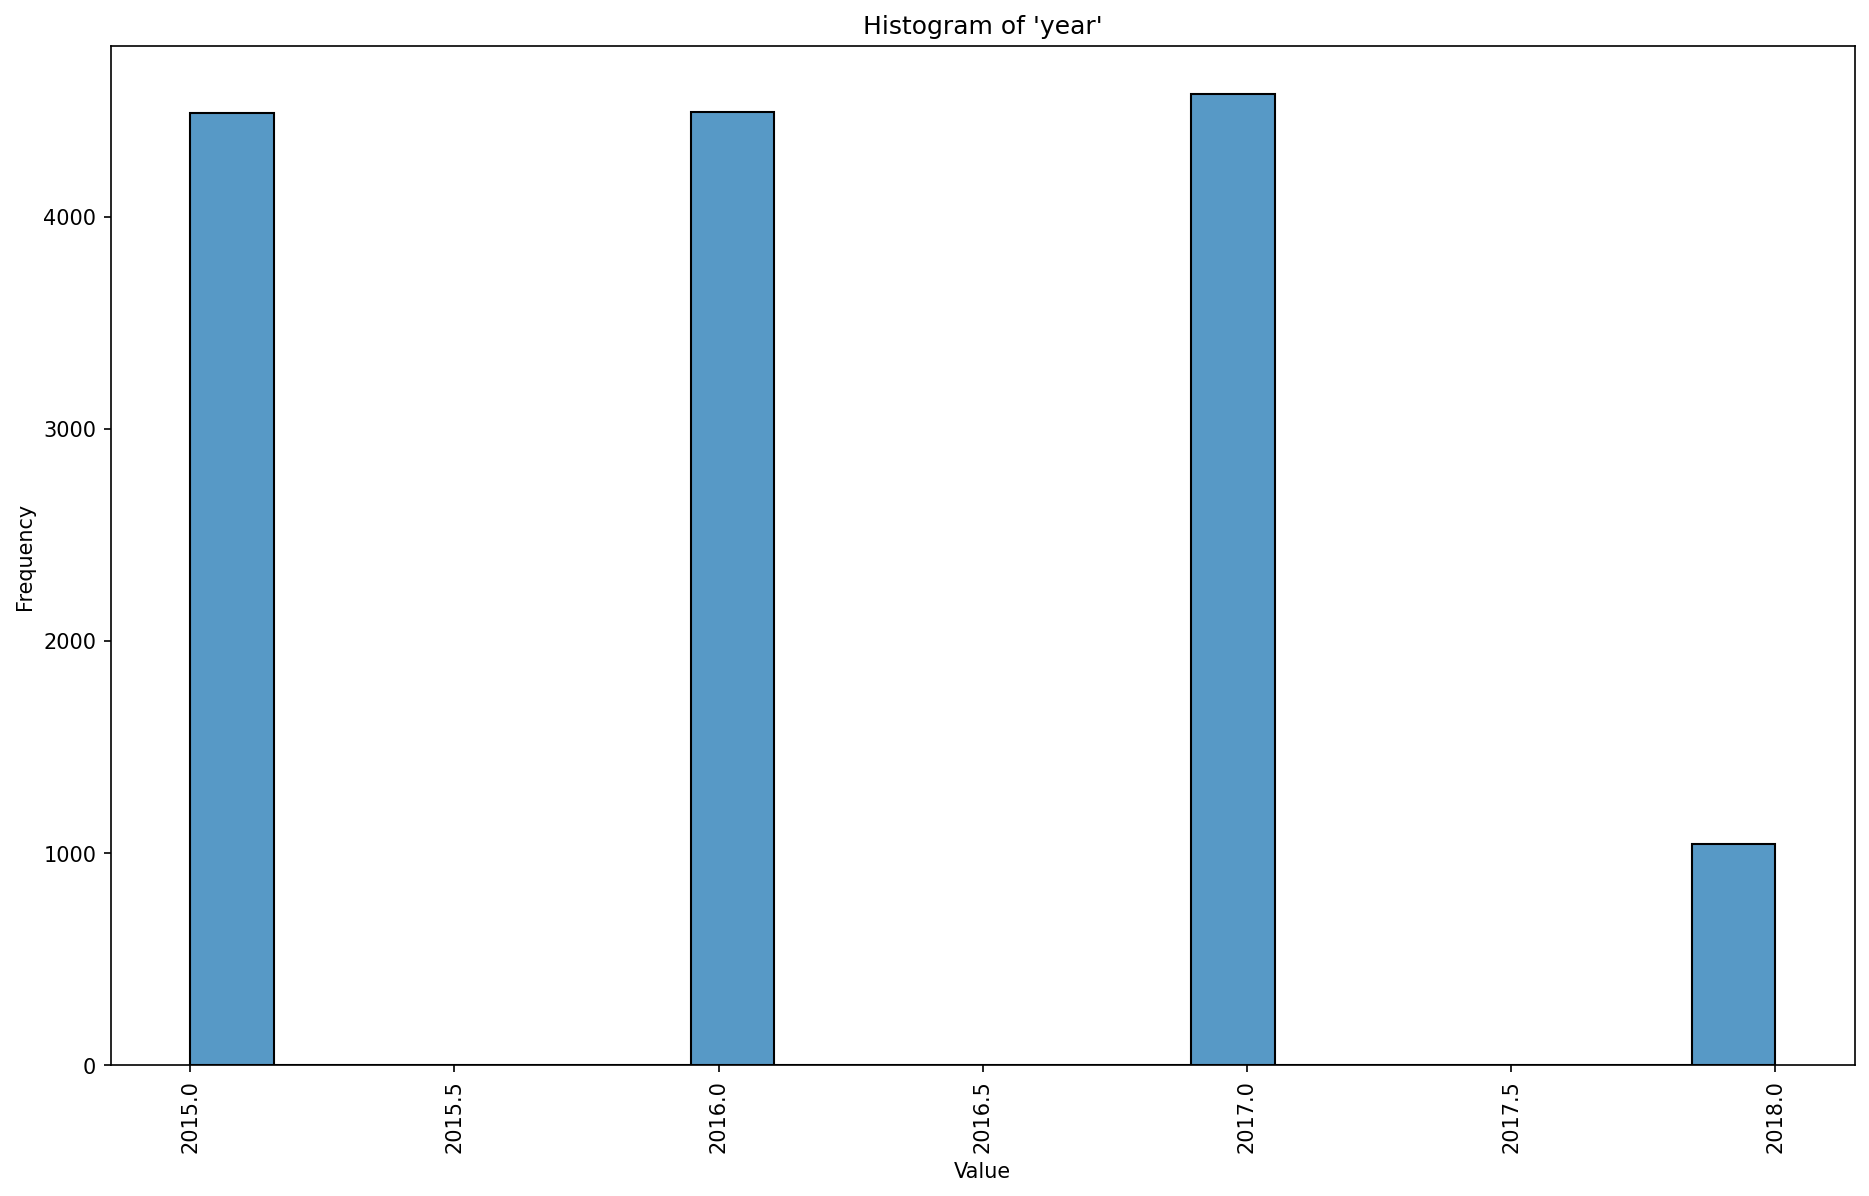

In [16]:
for i in numericals:
    plot_histogram(i,train)

* Average price seem to have some skewness but can be ignored and assumed it is normally distributed. No obvious outliers apperant in the histogram.
* Data appears to has has no obvious imbalance in terms of years.

array([[<AxesSubplot:xlabel='average_price', ylabel='average_price'>,
        <AxesSubplot:xlabel='total_volume', ylabel='average_price'>,
        <AxesSubplot:xlabel='4046', ylabel='average_price'>,
        <AxesSubplot:xlabel='4225', ylabel='average_price'>,
        <AxesSubplot:xlabel='4770', ylabel='average_price'>,
        <AxesSubplot:xlabel='total_bags', ylabel='average_price'>,
        <AxesSubplot:xlabel='small_bags', ylabel='average_price'>,
        <AxesSubplot:xlabel='large_bags', ylabel='average_price'>,
        <AxesSubplot:xlabel='xlarge_bags', ylabel='average_price'>,
        <AxesSubplot:xlabel='year', ylabel='average_price'>],
       [<AxesSubplot:xlabel='average_price', ylabel='total_volume'>,
        <AxesSubplot:xlabel='total_volume', ylabel='total_volume'>,
        <AxesSubplot:xlabel='4046', ylabel='total_volume'>,
        <AxesSubplot:xlabel='4225', ylabel='total_volume'>,
        <AxesSubplot:xlabel='4770', ylabel='total_volume'>,
        <AxesSubplot:xlabel='t

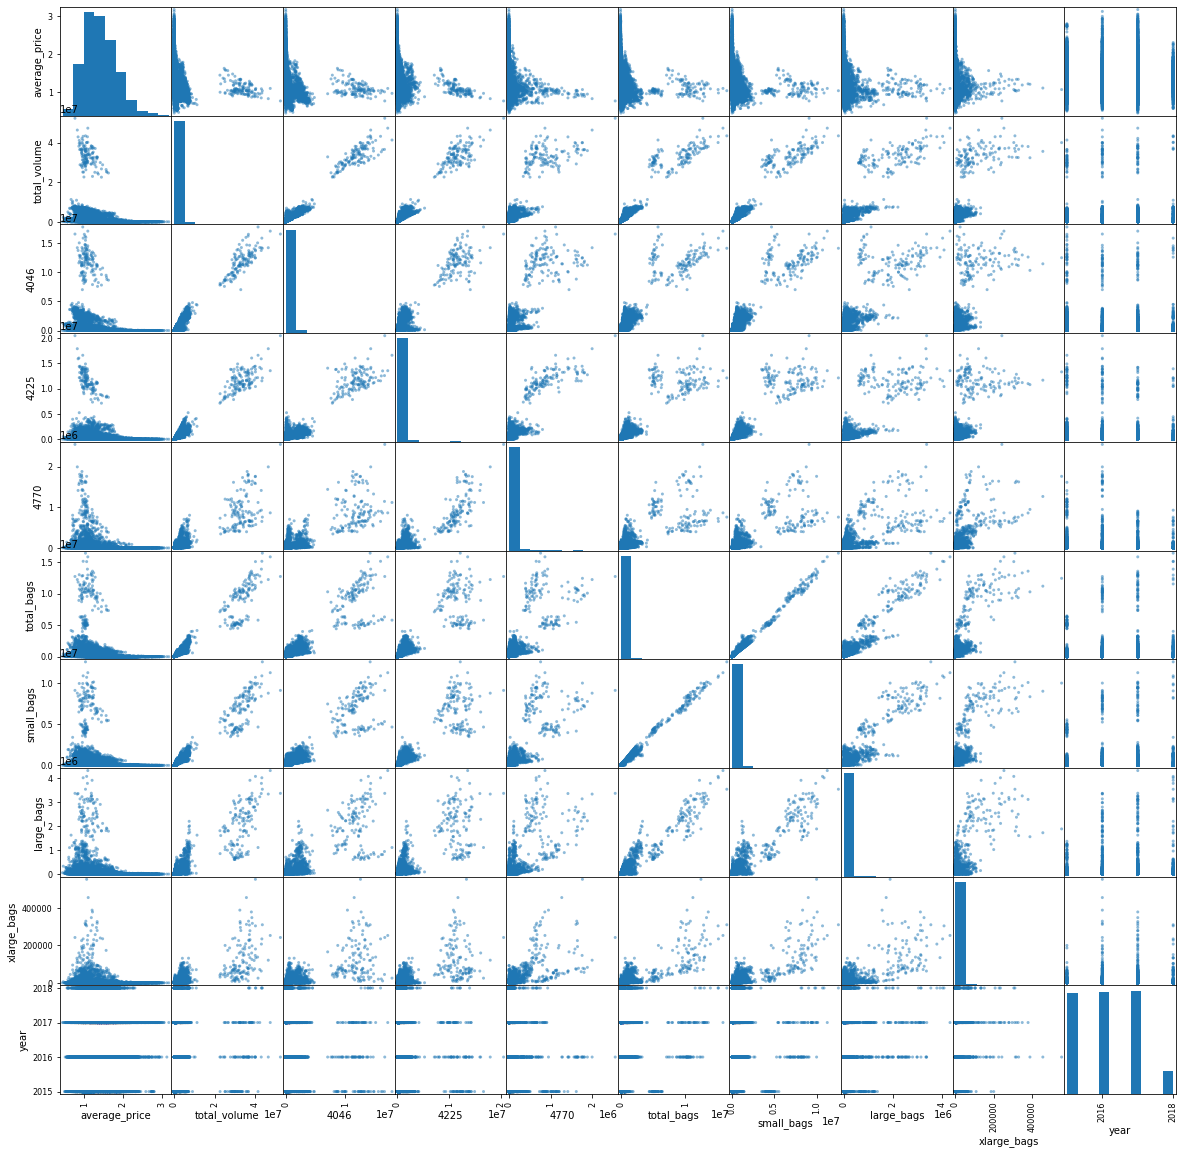

In [17]:
from pandas.plotting import scatter_matrix
scatter_matrix(train[numericals], figsize = (20,20))

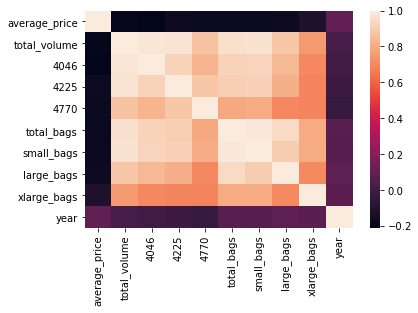

In [18]:
sns.heatmap(train.corr());

No strong corellation with average price with any of the variables is apperant in correlation matrix.

## Cleaning and Preparing Data  


In [19]:
X = train.drop(["average_price","date","year","region"],axis = 1) # for our analysis we neglect date, year and region variables
y = train.average_price

In [20]:
train.isnull().sum().sort_values(ascending=False).head()

date             0
average_price    0
total_volume     0
4046             0
4225             0
dtype: int64

There seem to be no missing data.

We need categorical variables in terms of numbers. For instance (not for everyone but) years should also be counted as categorical variable but since it is in increasing order and this increment has a meaning, therefore we treat it as a numerical variable. We apply get_dummies function of pandas to two categorical variables.

In [21]:
for i in categoricals:
    onehot = pd.get_dummies(X[i], prefix=i, dummy_na=False)
    X = X.drop(i, axis = 1)
    X = pd.concat([X, onehot], axis=1)

We need to scale the data since all values are scattered among different intervals. Without a proper normalization, ML algorithms does not give meaningful results in general.

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)

StandardScaler()

In [23]:
X_new = scaler.transform(X)

##  Try Different Models to Find an Appropriate One

* This notebook aims to predict average prices, therefore we will consider different regression algortihms and pick a good one among them. 
* Since we are using regression, we will use mean squared error as a measure of error. More specifically Root Mean Squared Error since it averages the squared errors with relatively high weight to large errors in the computation.

#### Linear Regression

In [24]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_new,y)

LinearRegression()

In [25]:
from sklearn.metrics import mean_squared_error
linreg_preds = linreg.predict(X_new)
linreg_mse = mean_squared_error(linreg_preds,y)
linreg_rmse = np.sqrt(linreg_mse)

In [26]:
linreg_rmse

0.31161300620401444

Is this prediction an overfitting?

In [27]:
from sklearn.model_selection import cross_val_score
linreg_crossval_scores = cross_val_score(linreg, X_new,y,scoring = "neg_mean_squared_error", cv = 10)

In [28]:
def display_scores(scores):
    print("scores:"  , scores)
    print("mean:", scores.mean())

In [29]:
display_scores(np.sqrt(-linreg_crossval_scores))

scores: [0.3162473  0.31169638 0.30896033 0.30063143 0.30674243 0.31004363
 0.31326295 0.32377    0.32001882 0.30580943]
mean: 0.3117182696062487


There seem to be no overfitting, but how successful is this value?

In [30]:
overview_data = X.iloc[40:50]
overview_labels = y.iloc[40:50]
scaled = scaler.transform(overview_data)
print("predicted", linreg.predict(scaled), "compare labels", overview_labels)

predicted [1.65451253 1.65467757 1.18379395 1.65448382 1.65447723 1.65508192
 1.65443725 1.14493033 1.65458467 1.65603602] compare labels 16568    1.58
10708    1.95
6561     1.59
10224    2.05
13332    1.39
13400    2.30
9389     1.57
1383     0.98
16998    2.73
15910    1.78
Name: average_price, dtype: float64


There seem to be some good and bad predictions. For instance 1.65 instead of 1.59 acceptable, also 1.65 instead of 2.73 seems unacceptable. Based on the predictions on these 10 observations, I feel like the model is doing bad, it is not enough to judge for now. Let us compare it with other models.

#### Decision Tree Regression


In [31]:
from sklearn.tree import DecisionTreeRegressor
dectreereg = DecisionTreeRegressor()
dectreereg.fit(X_new , y)
dectreereg_preds = dectreereg.predict(X_new)

In [32]:
dectreereg_mse = mean_squared_error(y,dectreereg_preds)
dectreereg_rmse = np.sqrt(dectreereg_mse)
dectreereg_rmse

8.115139258603455e-18

This error is negligible, almost 0. Is it really the case?

In [33]:
dectreereg_crossval_scores = cross_val_score(dectreereg, X_new,y,scoring = "neg_mean_squared_error", cv = 10)
display_scores(np.sqrt(-dectreereg_crossval_scores))

scores: [0.27698116 0.27346258 0.26906726 0.28363142 0.26840842 0.26301779
 0.27413913 0.27504632 0.28488823 0.2831273 ]
mean: 0.27517696013509274


This scores seems more meaningful, obviously decision tree regression is overfitting.

#### SVM Regression

In [34]:
from sklearn.svm import SVR
svmreg = SVR()
svmreg.fit(X_new,y)
svmreg_preds = svmreg.predict(X_new)

In [35]:
svmreg_mse = mean_squared_error(y,svmreg_preds)
svmreg_rmse = np.sqrt(svmreg_mse)
svmreg_rmse

0.2929777262141439

Is it a safe prediction? Let us see in cross validation.

In [36]:
svmreg_crossval_scores = cross_val_score(svmreg, X_new,y,scoring = "neg_mean_squared_error", cv = 10)
display_scores(np.sqrt(-svmreg_crossval_scores))

scores: [0.29979154 0.29502206 0.29038701 0.28035011 0.28850745 0.28901966
 0.29316658 0.30885154 0.30344581 0.28891202]
mean: 0.29374537735049966


#### Random Forest Regression

In [37]:
from sklearn.ensemble import RandomForestRegressor
ranforestreg = RandomForestRegressor()
ranforestreg.fit(X_new,y)

RandomForestRegressor()

In [38]:
ranforestreg_preds = ranforestreg.predict(X_new)
ranforestreg_mse = mean_squared_error(y,ranforestreg_preds)
ranforestreg_rmse = np.sqrt(ranforestreg_mse)
ranforestreg_rmse

0.07153788386583655

Seems so good, is it overfitting?

In [39]:
ranforestreg_crossval_scores = cross_val_score(ranforestreg, X_new,y,scoring = "neg_mean_squared_error", cv = 10)
display_scores(np.sqrt(-ranforestreg_crossval_scores))

scores: [0.18817744 0.19063882 0.19121265 0.19994386 0.19214445 0.18105873
 0.19265957 0.20122194 0.20177873 0.1985611 ]
mean: 0.19373972750687357


It was overfitting obviously, let us see if we can improve this model.

## Fine Tuning Random Forest Regressor


#### Grid Search Method

In [40]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators' : [3,10,30], 'max_features' : [2,4,6,8], "max_depth" : [10, 20],},
    {'bootstrap' : [False], 'n_estimators' : [4,8,12], 'max_features' : [2,3,4]}, 
    {'bootstrap' : [True], 'n_estimators' : [2,10,20], 'max_features' : [5,6,7]}
]

In [41]:
grid_search = GridSearchCV(ranforestreg, param_grid, cv = 10,
                          scoring = 'neg_mean_squared_error',
                          return_train_score = True
                          )

In [42]:
grid_search.fit(X_new,y)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid=[{'max_depth': [10, 20], 'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [4, 8, 12]},
                         {'bootstrap': [True], 'max_features': [5, 6, 7],
                          'n_estimators': [2, 10, 20]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [43]:
grid_search.best_params_

{'max_depth': 20, 'max_features': 4, 'n_estimators': 30}

In [44]:
bestregressor = grid_search.best_estimator_

What are most important features?

In [45]:
sorted(zip(bestregressor.feature_importances_, X.columns))

[(0.02459620950609976, 'xlarge_bags'),
 (0.05904747717544178, '4770'),
 (0.07707426219025357, 'small_bags'),
 (0.10112202604402092, 'total_bags'),
 (0.10342593603788121, 'large_bags'),
 (0.10426094602145643, '4225'),
 (0.12778463208870985, '4046'),
 (0.13253661121257515, 'total_volume'),
 (0.1325426636345828, 'type_conventional'),
 (0.13760923608897851, 'type_organic')]

## Evaluate the System on the Test Set

In [46]:
X_test = test.drop(["date","average_price","year","region"],axis = 1)
y_test = test.average_price

We are supposed to apply same transformations on the test set

In [47]:
for i in categoricals:
    onehot = pd.get_dummies(X_test[i], prefix=i, dummy_na=False)
    X_test = X_test.drop(i, axis = 1)
    X_test = pd.concat([X_test, onehot], axis=1)

In [48]:
X_test_latest = scaler.transform(X_test)

In [49]:
bestregressor_preds = bestregressor.predict(X_test_latest)
bestregressor_mse = mean_squared_error(y_test,bestregressor_preds)
bestregressor_rmse = np.sqrt(bestregressor_mse)
bestregressor_rmse

0.19701119230321956

In [50]:
bestregressor_crossval_scores = cross_val_score(bestregressor, X_test_latest,y_test,scoring = "neg_mean_squared_error", cv = 10)
display_scores(np.sqrt(-bestregressor_crossval_scores))

scores: [0.24610945 0.2262049  0.21802972 0.22408024 0.24893908 0.22150819
 0.22362925 0.22163988 0.23084587 0.23297881]
mean: 0.22939653932803053


## Conclusion
    * In this notebook, linear regression, decision tree regression, svm regression and random forest regression models were compared
    * To further improve random forest regression model, grid search method applied to find best parameters
    * type and 4046 seem to be the best parameters to predict average price.